# Daily + weekly + yearly seasonality model

Modelling both daily and weekly seasonality with gaussian process on $log(lambda)$. Modelling yearly seasonality as a scale factor on $lambda$, centered around 1.

Next step after this is to include weather effects.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import polars as pl
import numpy as np
import scipy

import pymc as pm
import arviz as az

import warnings

sns.set(rc={'figure.figsize':(17,11)})

warnings.filterwarnings("ignore")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
data = pl.read_parquet("../data/counter_data.parquet").with_columns(pl.col("weekday") - 1)

In [3]:
data.select(pl.col("site_name").unique()).to_numpy()

array([['Basin Reserve'],
       ['Oriental Parade Shared Path'],
       ['Oriental Cycle Sign Virtual 2 Bins'],
       ['Mt Vic Tunnel'],
       ['Oriental Road'],
       ['Tawa Shared Path (Southern end)'],
       ['Salamanca Road'],
       ['Tasman Street'],
       ['Willis St'],
       ['Evans Bay'],
       ['Hutt Road Cycle Sign Virtual'],
       ['Adelaide Road'],
       ['Airport Tunnel Counter'],
       ['Brooklyn Road - up hill'],
       ['Hutt Road Shared Path'],
       ['Crawford'],
       ['Cobham Drive Shared Path'],
       ['Tawa Shared Path (At Kenepuru)'],
       ['Thorndon Quay'],
       ['Glenmore Street'],
       ['Willowbank'],
       ['Evans Bay Shared Path'],
       ['Burma Road']], dtype=object)

In [49]:
filtered_data = data.filter(
    (pl.col("year") == 2022) &
    (pl.col("site_name") == "Thorndon Quay")
).with_columns(
    pl.col("count_outgoing").fill_null(0),
    (
        (
            pl.col("record_time").dt.date() - date(year=2022, month=1, day=1)
        ).dt.days()
    ).alias("day_in_year")
)

In [ ]:
sns.relplot(
    data.filter(
        (pl.col("hour") >= 7) & 
        (pl.col("hour") <= 9) &
        (pl.col("weekday") < 5)
    ).group_by(
        "day_in_year"
    ).agg(
        pl.col("count_outgoing").mean().alias("mean_count")
    ),
    x="day_in_year",
    y="mean_count"
)

In [115]:
filtered_data.filter(
        (pl.col("hour") >= 7) & 
        (pl.col("hour") <= 9) &
        (pl.col("weekday") < 5)
    ).set_sorted(
        "record_time"
    ).group_by_dynamic(
        "record_time",
        every="1w"
    ).agg(
        pl.col("count_outgoing").sum().alias("day_count")
    )

record_time,day_count
"datetime[μs, UTC]",i64
2022-01-03 00:00:00 UTC,308
2022-01-10 00:00:00 UTC,1467
2022-01-17 00:00:00 UTC,1868
2022-01-24 00:00:00 UTC,897
2022-01-31 00:00:00 UTC,1353
2022-02-07 00:00:00 UTC,1073
2022-02-14 00:00:00 UTC,1173
2022-02-21 00:00:00 UTC,1187
2022-02-28 00:00:00 UTC,977


(0.0, 7000.0)

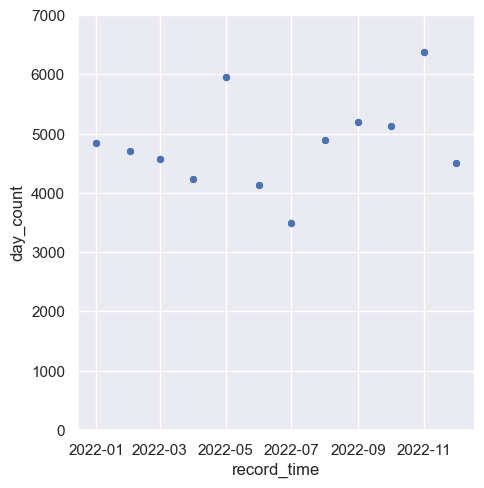

In [122]:
sns.relplot(
    filtered_data.filter(
        (pl.col("hour") >= 7) & 
        (pl.col("hour") <= 9) &
        (pl.col("weekday") < 5)
    ).set_sorted(
        "record_time"
    ).group_by_dynamic(
        "record_time",
        every="1mo"
    ).agg(
        pl.col("count_outgoing").sum().alias("day_count")
    ),
    x="record_time",
    y="day_count"
)
plt.ylim(0,7000)

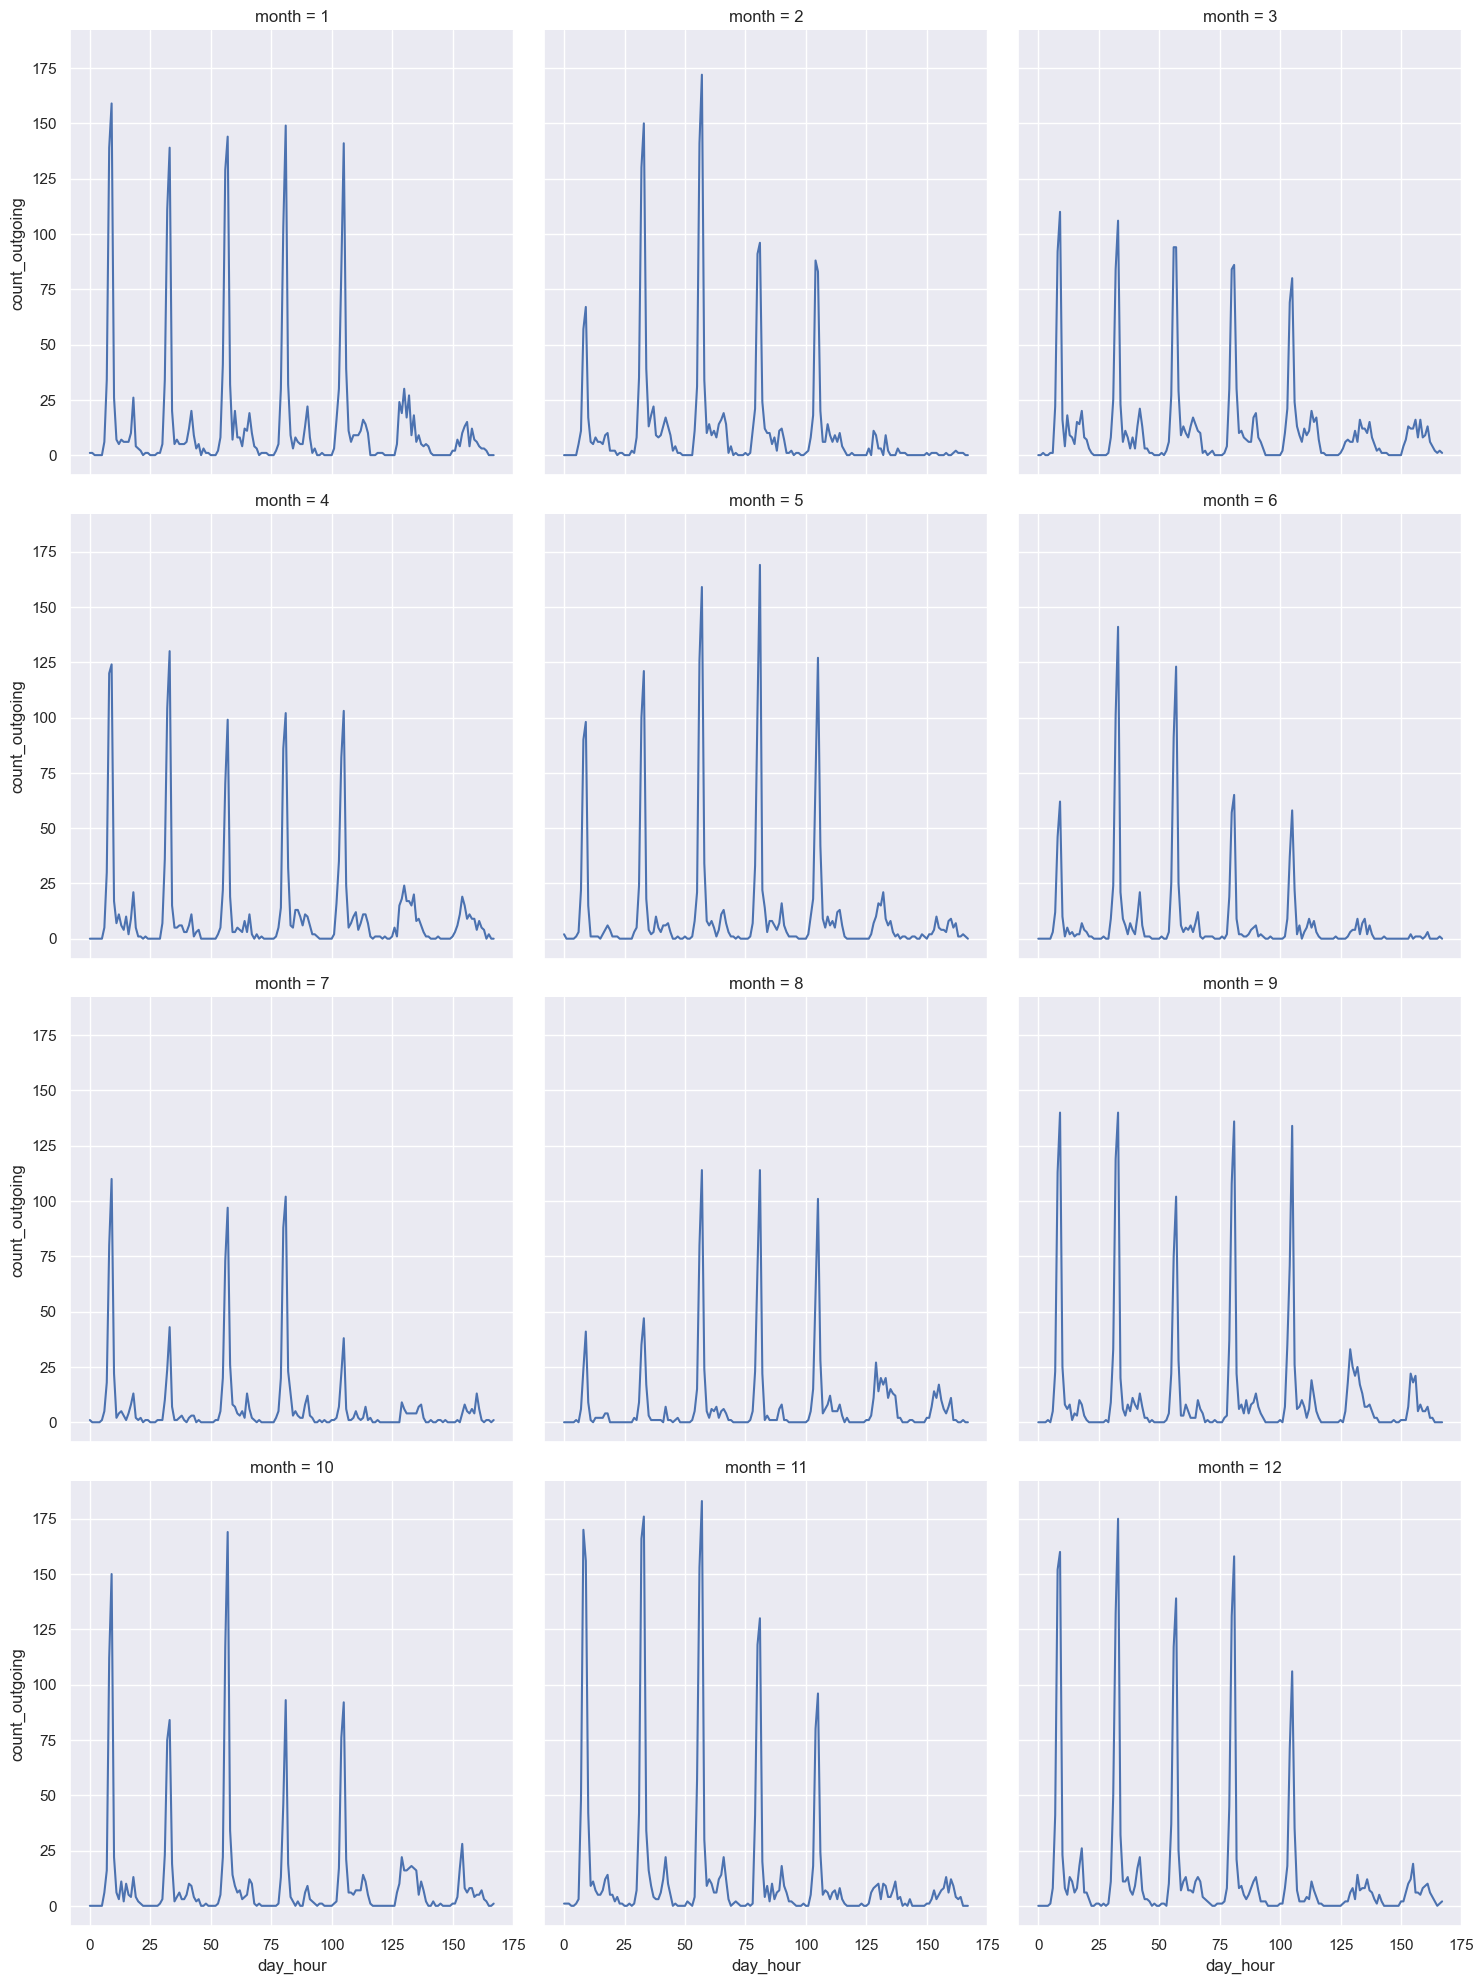

In [5]:
sns.relplot(
    (
        filtered_data.filter(
            (pl.col("day") > 7) & (pl.col("day") <= 14)
        ).with_columns(
            (pl.col("weekday") * 24 + pl.col("hour")).alias("day_hour")
        )
    ),
    x="day_hour", 
    y="count_outgoing",
    kind="line",
    col="month",
    col_wrap=3,
)

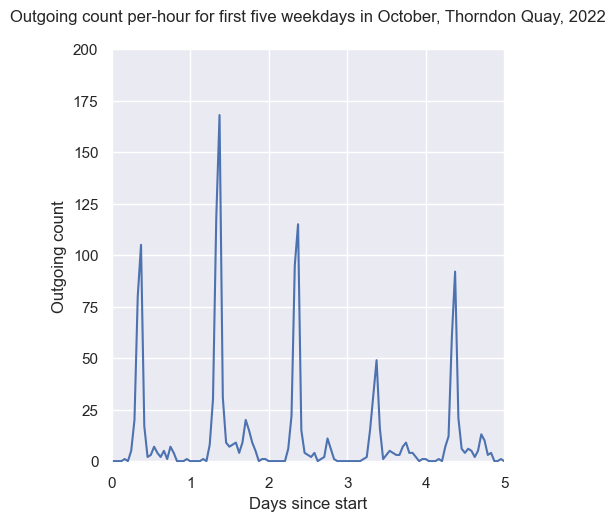

In [6]:
sns.relplot(
    (
        filtered_data.filter(
            (pl.col("month") == 10) &
            (pl.col("day") <= 7)
        )
        .with_columns(
            (pl.col("weekday") * 24 + pl.col("hour")).alias("day_hour")
        )
    ), 
    x="day_hour", 
    y="count_outgoing",
    kind="line"
)
plt.xlabel("Days since start")
plt.ylabel("Outgoing count")
plt.ylim(-1,200)
plt.xlim(0,24*5)
plt.xticks([24*i for i in range(6)], list(range(6)))
plt.title("Outgoing count per-hour for first five weekdays in October, Thorndon Quay, 2022", pad=20);

Model describes bike count $c_i$ as GammaPoisson distribution conditional on time of day, for data sampled where: 

- location = "Thorndon Quay"
- year = 2022
- day = {monday, tuesday, wednesday, thursday, friday}
- direction = "Outgoing"

$hour[i]$ is indexed hour of day for sample $i$, with "12am-1am" = 0. 

\begin{align}
c_i &\sim GammaPoisson(\phi, \mu_i) \\
\log{(\mu_i)} &= \lambda_{hour[i]} \\
\lambda_{j = 0..23} &\sim MVNormal([0,0,\dots,0]^T, K) \\
K &= Periodic(24, \tau) \\
\phi &\sim Exponential(1) \\
\tau &\sim Exponential(0.1)
\end{align}

In [7]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

In [33]:
X

array([[3.00068446],
       [3.00342231],
       [3.00616016],
       [3.00889802],
       [3.01163587],
       [3.01437372],
       [3.01711157],
       [3.01984942],
       [3.02258727],
       [3.02532512],
       [3.02806297],
       [3.03080082],
       [3.03353867],
       [3.03627652],
       [3.03901437],
       [3.04175222],
       [3.04449008],
       [3.04722793],
       [3.04996578],
       [3.05270363],
       [3.05544148],
       [3.05817933],
       [3.06091718],
       [3.06365503],
       [3.06639288],
       [3.06913073],
       [3.07186858],
       [3.07460643],
       [3.07734428],
       [3.08008214],
       [3.08281999],
       [3.08555784],
       [3.08829569],
       [3.09103354],
       [3.09377139],
       [3.09650924],
       [3.09924709],
       [3.10198494],
       [3.10472279],
       [3.10746064],
       [3.11019849],
       [3.11293634],
       [3.1156742 ],
       [3.11841205],
       [3.1211499 ],
       [3.12388775],
       [3.1266256 ],
       [3.129

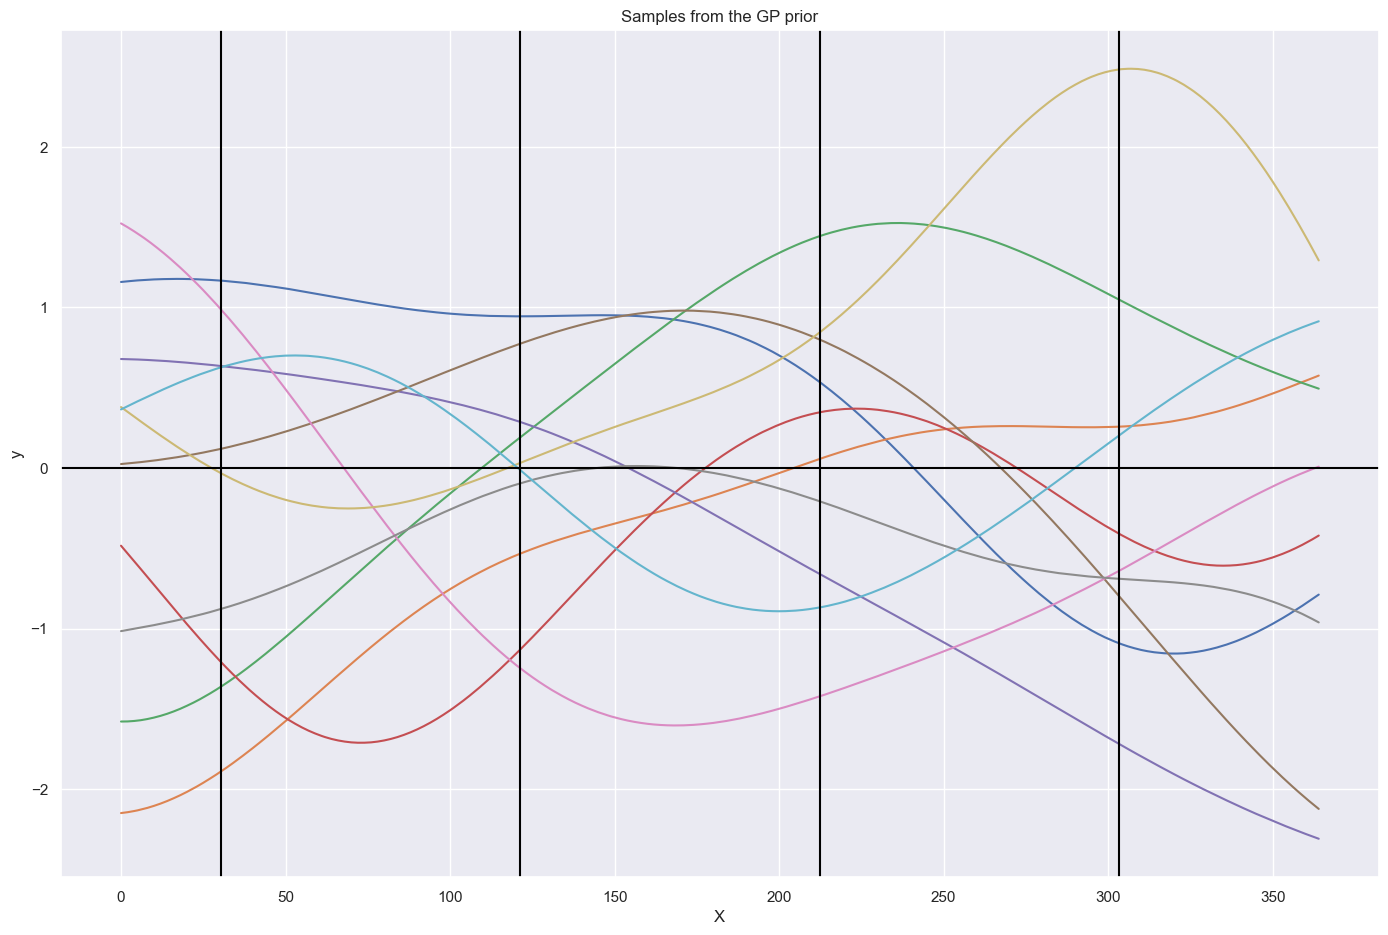

In [87]:
X = np.array(filtered_data.select("day_in_year").unique(maintain_order=True))

period = 365
ls = 90
cov1 = pm.gp.cov.Periodic(1, period=period, ls=ls)
cov2 = pm.gp.cov.ExpQuad(1, 90)
cov = cov1 * cov2
cov += pm.gp.cov.WhiteNoise(1e-4)

K = cov(X).eval()
plt.plot(
    X,
    pm.draw(pm.MvNormal.dist(mu=np.zeros(len(K)), cov=K, shape=len(K)), draws=10, random_seed=rng).T,
)
for p in (np.linspace(X.min(), X.max(), 5) + (X.max() - X.min())/12)[:-1]:
    plt.axvline(p, color="black")
plt.axhline(0, color="black")
plt.title("Samples from the GP prior")
plt.ylabel("y")
plt.xlabel("X");

In [31]:
X

array([[3.00068446],
       [3.00342231],
       [3.00616016],
       [3.00889802],
       [3.01163587],
       [3.01437372],
       [3.01711157],
       [3.01984942],
       [3.02258727],
       [3.02532512],
       [3.02806297],
       [3.03080082],
       [3.03353867],
       [3.03627652],
       [3.03901437],
       [3.04175222],
       [3.04449008],
       [3.04722793],
       [3.04996578],
       [3.05270363],
       [3.05544148],
       [3.05817933],
       [3.06091718],
       [3.06365503],
       [3.06639288],
       [3.06913073],
       [3.07186858],
       [3.07460643],
       [3.07734428],
       [3.08008214],
       [3.08281999],
       [3.08555784],
       [3.08829569],
       [3.09103354],
       [3.09377139],
       [3.09650924],
       [3.09924709],
       [3.10198494],
       [3.10472279],
       [3.10746064],
       [3.11019849],
       [3.11293634],
       [3.1156742 ],
       [3.11841205],
       [3.1211499 ],
       [3.12388775],
       [3.1266256 ],
       [3.129

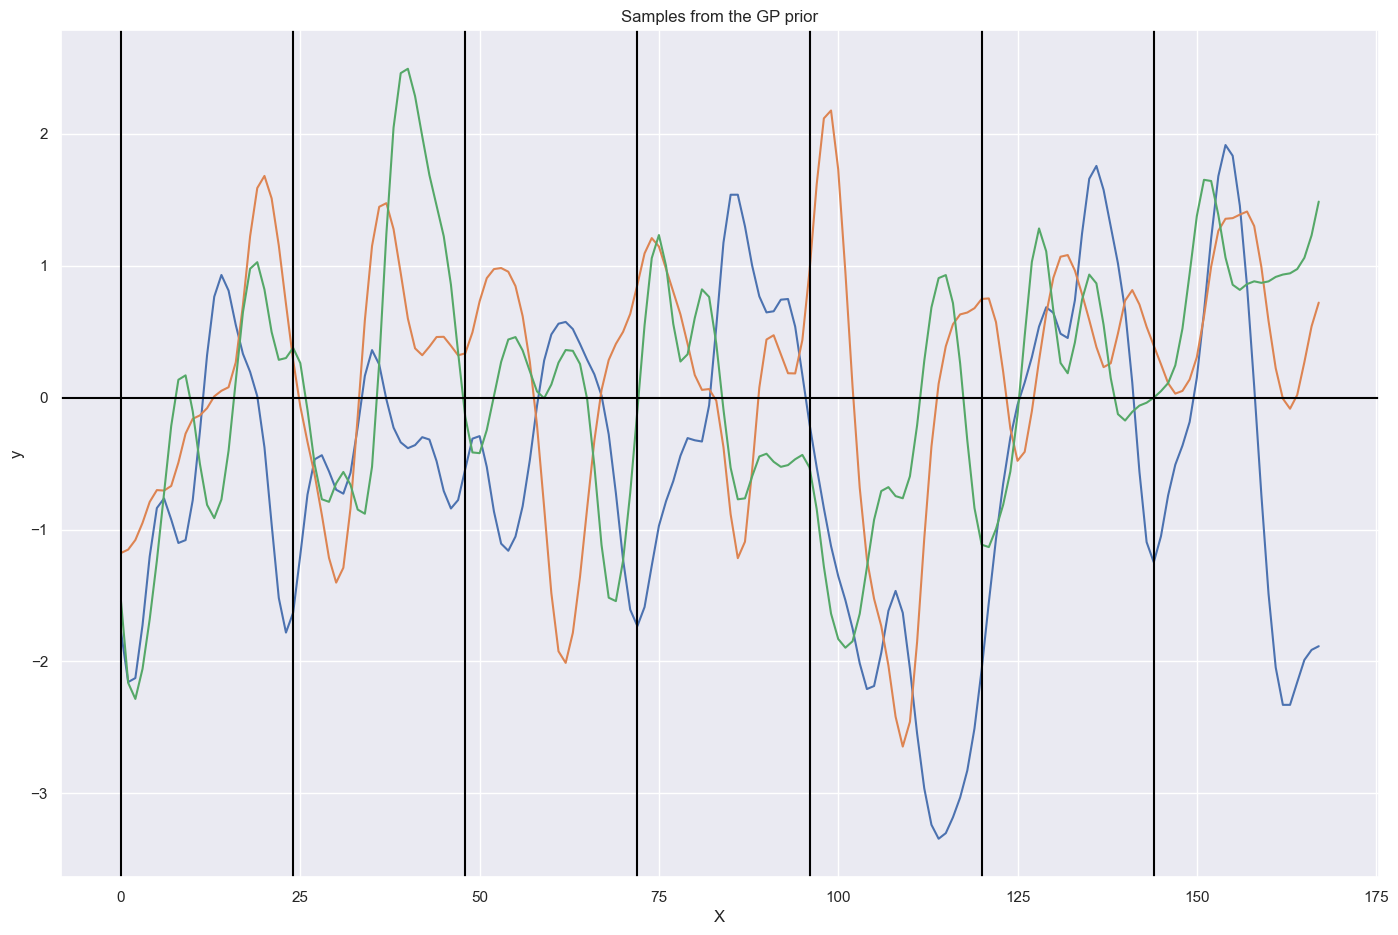

In [8]:
X = np.arange(24*7)[:, None]
# X = np.arange(24*3)[:, None]

period = [24, 24*7]
ls = [0.5, 24]
cov1 = pm.gp.cov.Periodic(1, period=period[0], ls=ls[0])
cov2 = pm.gp.cov.ExpQuad(1, 6)
cov3 = pm.gp.cov.Periodic(1, period=period[1], ls=ls[1])
cov = cov1 * cov2 * cov3
# Add white noise to stabilise
cov += pm.gp.cov.WhiteNoise(1e-6)

K = cov(X).eval()
plt.plot(
    X,
    pm.draw(pm.MvNormal.dist(mu=np.zeros(len(K)), cov=K, shape=len(K)), draws=3, random_seed=rng).T,
)
for p in np.arange(0, 24*7, 24):
    plt.axvline(p, color="black")
plt.axhline(0, color="black")
plt.title("Samples from the GP prior")
plt.ylabel("y")
plt.xlabel("X");

In [11]:
from datetime import date

record_time
f64
3.000684
3.000684
3.000684
3.000684
3.000684
3.000684
3.000684
3.000684
3.000684


In [103]:
2.81 ** -0.1

0.9018397383864409

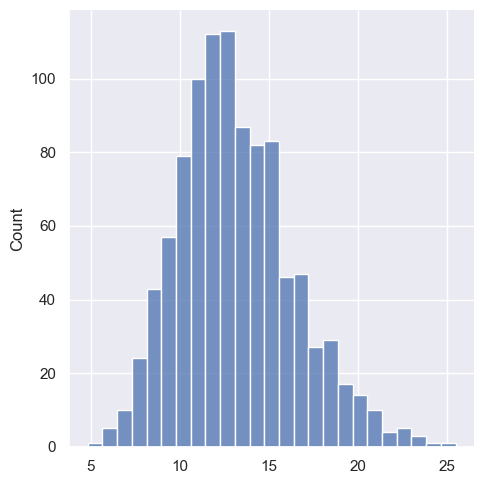

In [225]:
sns.displot(scipy.stats.gamma.rvs(10,3, size=1000))

In [251]:
with pm.Model() as m_4:
    hour = pm.MutableData("hour", np.array(filtered_data["hour"]), dims="obs_id")
    weekday = pm.MutableData("weekday", np.array(filtered_data["weekday"]), dims="obs_id")
    month = pm.MutableData("month", np.array(filtered_data["month"]) - 1, dims="obs_id")
    
    ls = pm.Exponential("ls", scale=[2, 1, 24])
    
    # hourly periodic effect
    cov_daily = pm.gp.cov.Periodic(1, period=24, ls=ls[0])
    
    # allowing variability to 24-hour period
    cov_daily *= pm.gp.cov.ExpQuad(1, ls=ls[1])
    
    # weekly periodic effect
    cov_weekly = pm.gp.cov.Periodic(1, period=24*7, ls=ls[2])
    
    # altogether
    cov = cov_daily * cov_weekly + pm.gp.cov.WhiteNoise(1e-4)
    
    # sample hourly * daily alphas
    K = cov(np.arange(24 * 7)[:, None]).eval()
    # alpha_raw = pm.MvNormal("alpha_raw", 0, 1, size=len(K))
    mu = pm.Normal("mu", 0, 1, shape=len(K))
    alpha = pm.MvNormal("alpha", mu=mu, cov=K, shape=len(K))
    lmda = pm.Deterministic("lmda", np.exp(alpha))
    
    # Monthly multiplier
    nu = pm.Beta("nu", 12, 1.25, size=12)
    
    # sample from Gamma Poisson
    phi = pm.Exponential("phi", scale=3)
    
    c = pm.NegativeBinomial(
        "c", 
        alpha=phi, 
        mu=lmda[weekday * 24 + hour] * nu[month], 
        observed=np.array(filtered_data["count_outgoing"]), 
        dims="obs_id"
    )
    
    m_4.debug(verbose=True)
    # trace = pm.sample_prior_predictive(1000)
    trace = pm.sample(10000, tune=10000)
    trace.extend(pm.sample_posterior_predictive(trace))
    

point={'ls_log__': array([0.69314718, 0.        , 3.17805383]), 'mu': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'alpha': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ls, mu, alpha, nu, phi]


Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 246 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [c]


In [252]:
trace

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data
	> constant_data

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

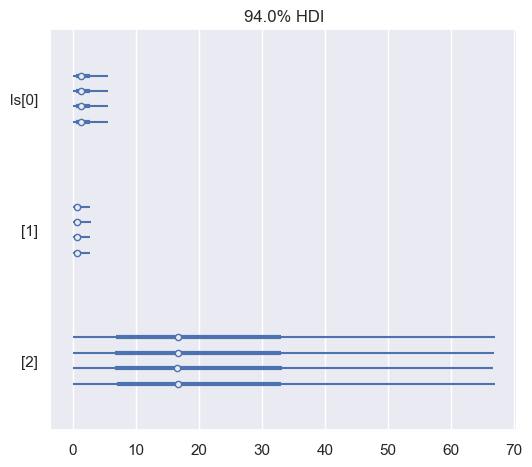

In [253]:
az.plot_forest(trace, var_names=["ls"])

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

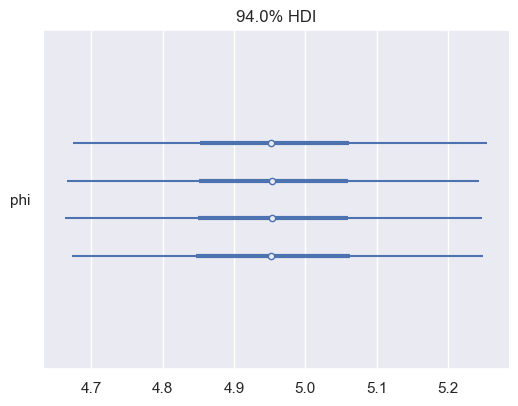

In [254]:
az.plot_forest(trace, var_names=["phi"])

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

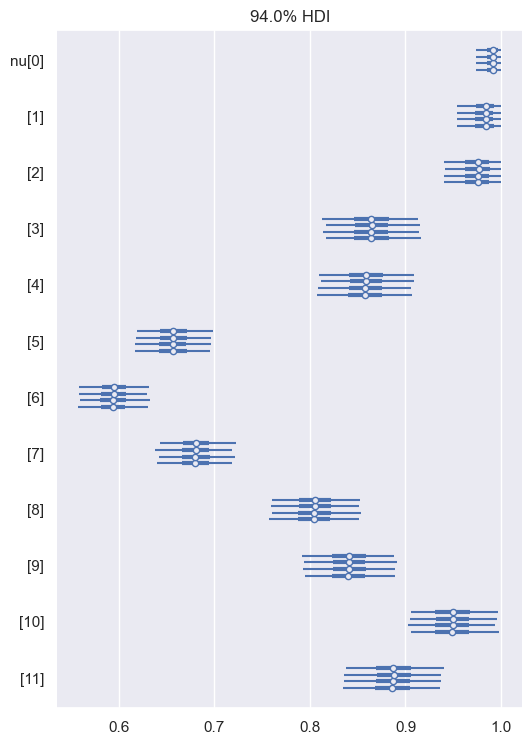

In [255]:
az.plot_forest(trace, var_names=["nu"])

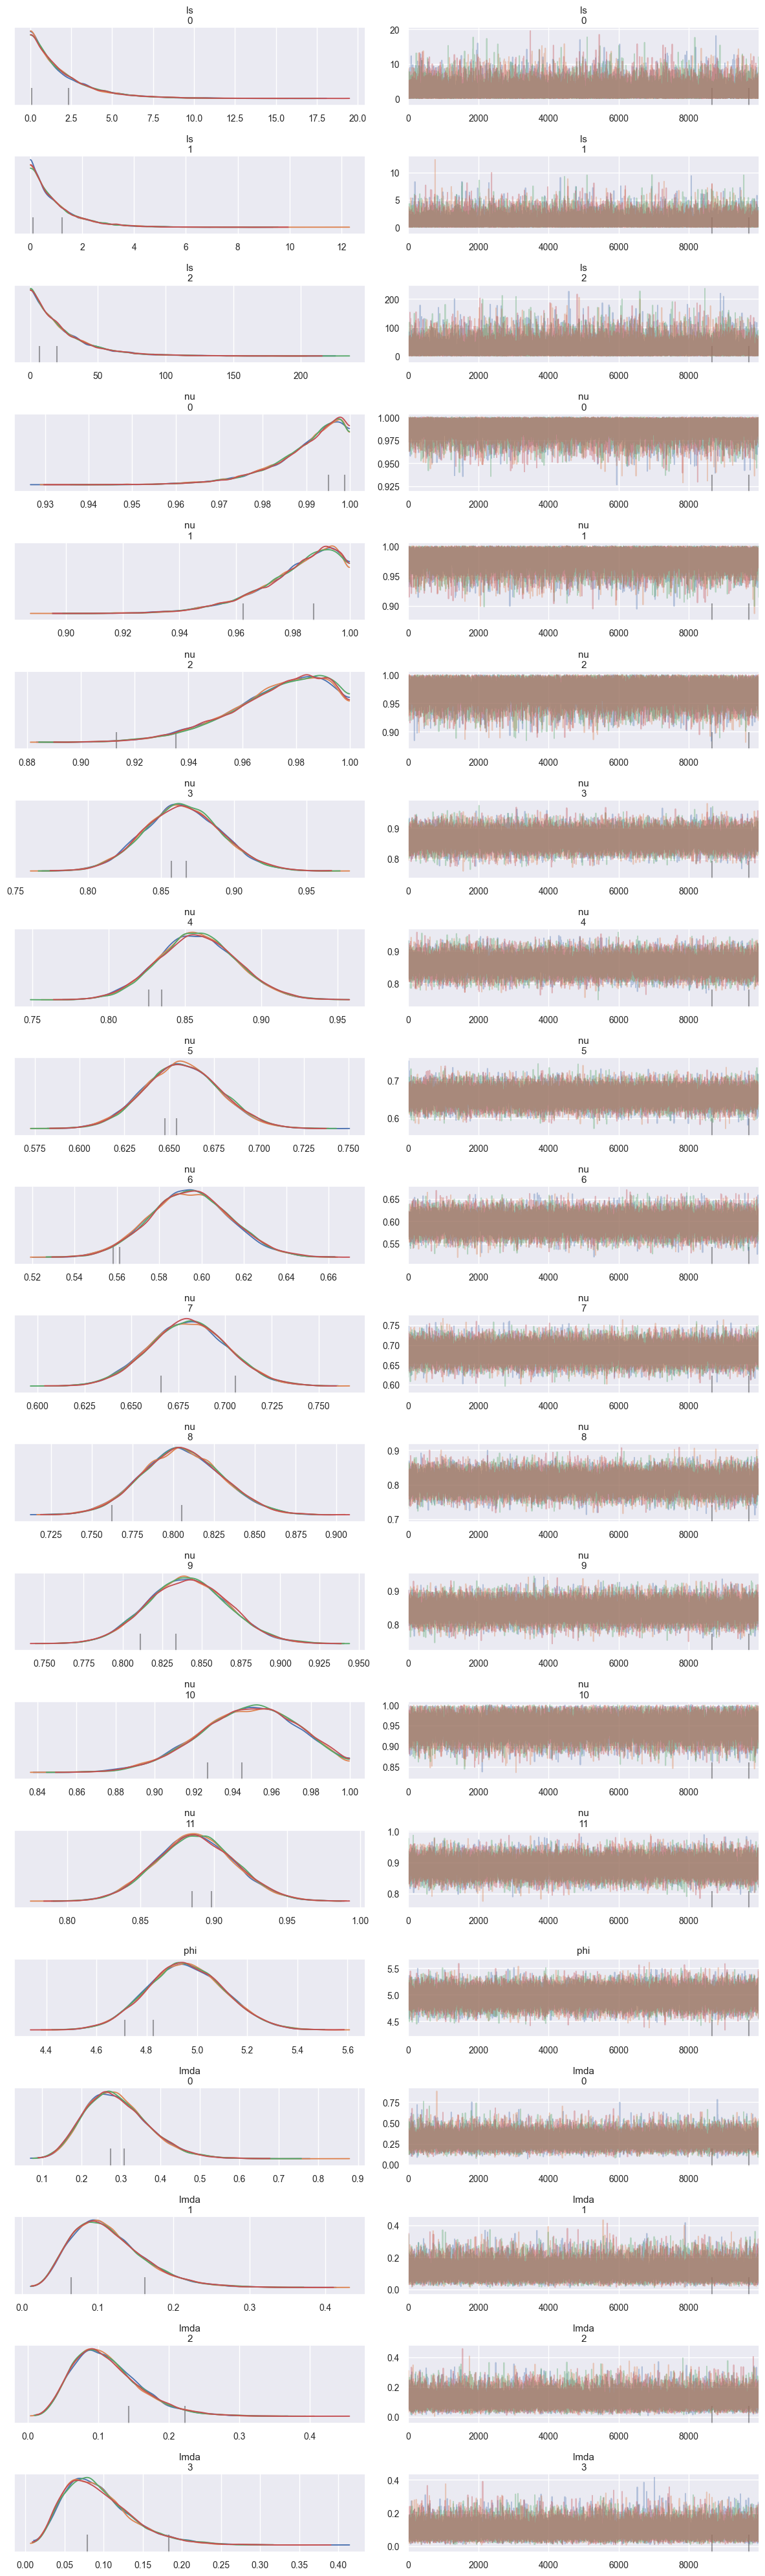

In [256]:
az.plot_trace(trace, compact=False, var_names=["ls", "nu", "phi", "lmda"]);
plt.tight_layout()

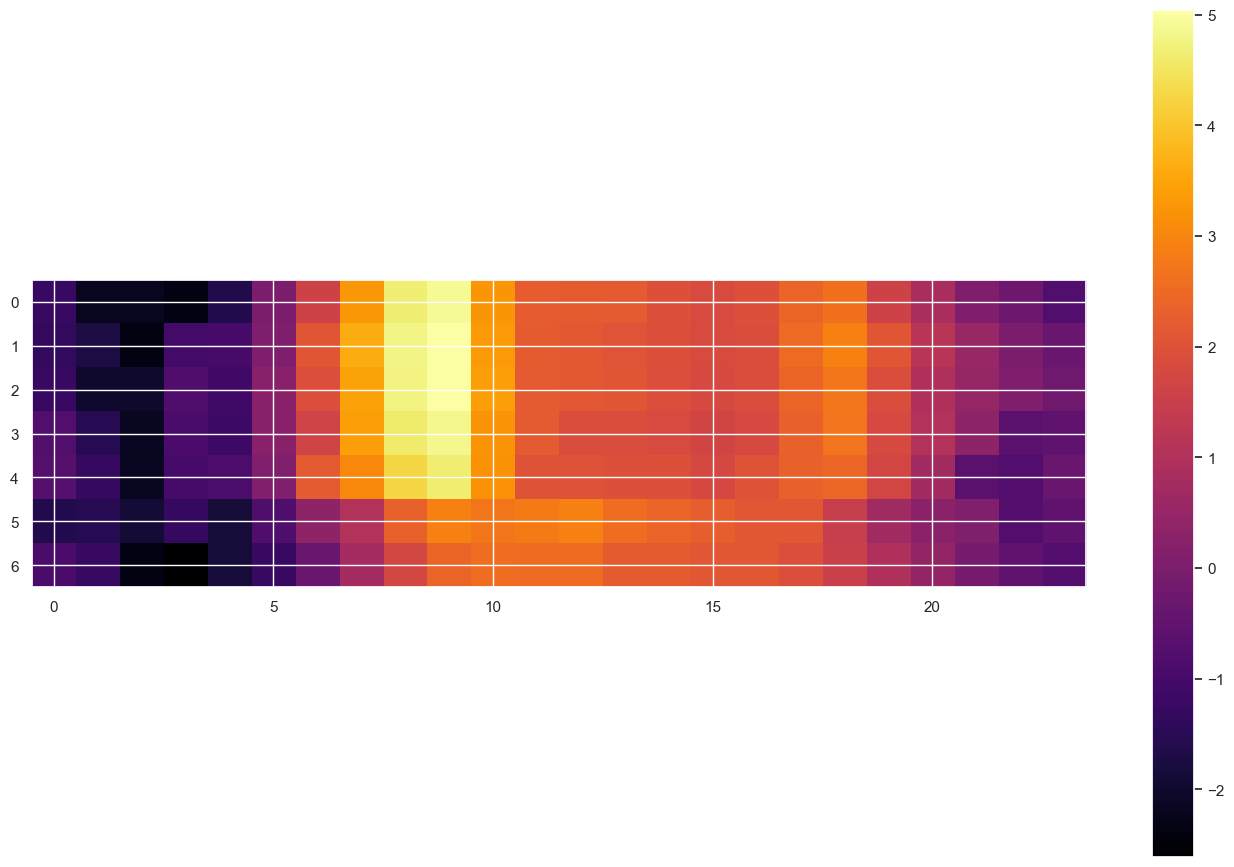

In [258]:
m = plt.imshow(np.log(np.array(az.extract(trace.posterior)["lmda"]).mean(axis=1).reshape((7, 24))), cmap="inferno", interpolation=None)
plt.colorbar(m)

In [259]:
post_preds = np.array(az.extract(trace.posterior_predictive)["c"])
post_preds.shape

(8759, 40000)

In [260]:
8759 / 24

364.9583333333333

In [261]:
day_post_preds = np.array([post_preds[i*24:(i+1)*24] for i in range(7)])
post_means = day_post_preds.mean(axis=2)
post_stds = day_post_preds.std(axis=2)

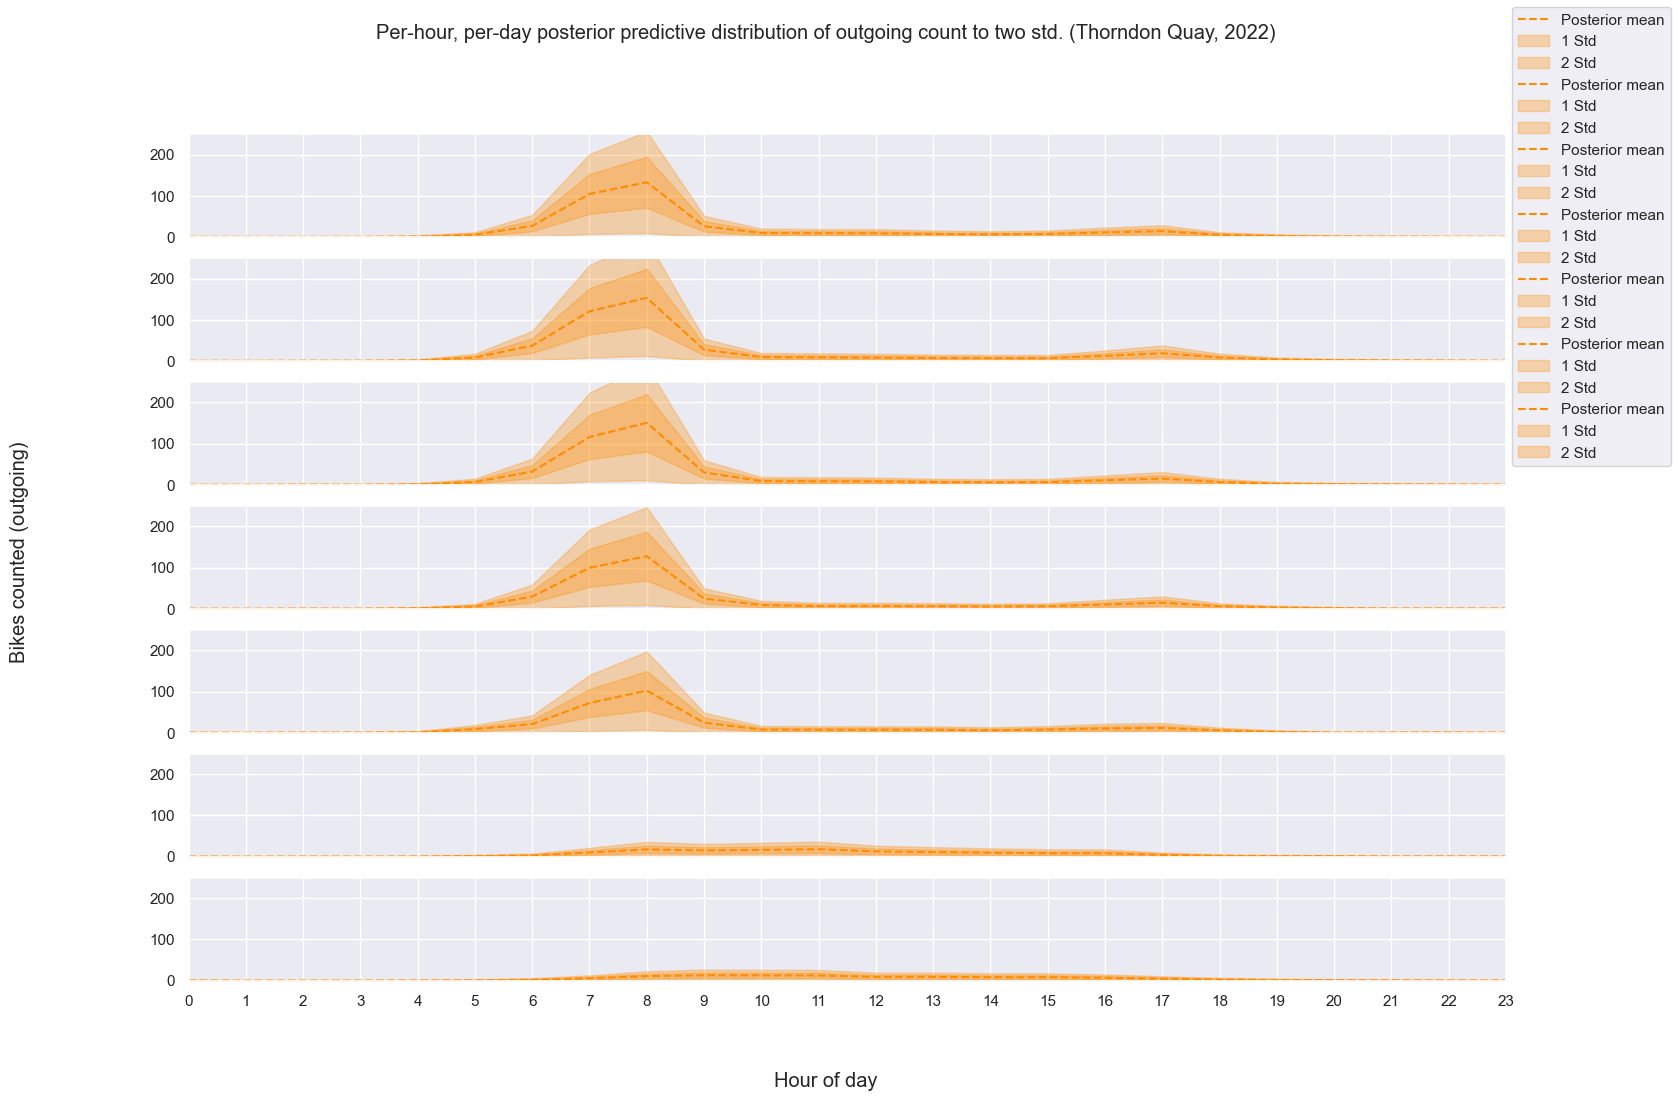

In [262]:
hours = np.arange(24)

# obs_mean = observed_stats.select("count_mean").to_numpy().flatten()

# post_mean = post_preds[:24].mean(axis=1)
# post_std = post_preds[:24].std(axis=1)

# plt.plot(hours, obs_mean, label="Observation mean", color="blue")
fig, axs = plt.subplots(nrows=7, sharex=True, sharey=True)
for i, (mean, std) in enumerate(zip(post_means, post_stds)):
    ax = axs[(i+5) % 7]
    ax.plot(hours, mean, label="Posterior mean", color="darkorange", linestyle="--")
    ax.fill_between(hours, (mean - std).clip(min=0), (mean + std), alpha=0.3, label="1 Std", color="darkorange")
    ax.fill_between(hours, (mean - 2*std).clip(min=0), (mean + 2*std), alpha=0.3, label="2 Std", color="darkorange")

plt.xticks(hours)
plt.xlim(0,23)
plt.ylim(-1,250)

# fig.supxlabel
fig.supxlabel("Hour of day")
fig.supylabel("Bikes counted (outgoing)")
fig.legend(loc="upper right")
plt.suptitle("Per-hour, per-day posterior predictive distribution of outgoing count to two std. (Thorndon Quay, 2022)")
plt.show()